In [1]:
# !pip install --upgrade astropy This fixed shit

# Basic packages
import numpy as np
import time
import sys
import os
from pathlib import Path
import logging
import importlib
# import mysql.connector

import pandas as pd
pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings("ignore")

# Astropy packages
from astropy.table import Table
from astropy.io import fits

# Matplotlib packages
import matplotlib.pyplot as plt

# Scipy
import scipy
from scipy.optimize import curve_fit
from scipy import signal


import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore')


# Useful if working in SSH Vscode
working_directory = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis'
os.chdir(working_directory)
import AnalysisFunctions as af
from stellarmodel import StellarModel



sys.path.append(os.path.join(working_directory, 'utils'))
import AstroPandas as ap
import DataFunctions as df

# Accepts mass, log(age), metallicity. Outputs Teff, logg, and log(L) bolometric (flux)
# isochrone_table = Table.read(working_directory +  '/assets/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
# isochrone_interpolator = af.load_isochrones()

isochrone_table = af.load_isochrones(type='trilinear')

# Results from CCF
results_text = pd.read_csv("/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis" + "/CCF_results.txt", sep='\t', names=["sobject_id", "no_peaks", "RVs"])
results_text['index'] = results_text.index

GALAH_DR4_dir = '/avatar/buder/GALAH_DR4/'
if 'GALAH_DR4' not in locals():
    GALAH_DR4 = df.FitsToDF(GALAH_DR4_dir + "catalogs/galah_dr4_allspec_240207.fits")
    # GALAH_DR4 = ap.FitsToDF("/avatar/yanilach/PhD-Home/binaries_galah-main/catalogs/galah_dr4_allspec_240207.fits")
    
isochrone_table

Isochrone interpolator found. Loading from file.
Loading tri-linear interpolator.


<Table length=3929146>
 logAge    m_h        mini       logT    logg    logL 
float64  float64    float64    float64 float64 float64
-------- -------- ------------ ------- ------- -------
    6.19 -2.19174 0.1000000015  3.5778   3.644  -0.943
    6.19 -2.19174 0.1062082499  3.5795   3.667  -0.935
    6.19 -2.19174 0.1098214313  3.5804   3.681  -0.931
    6.19 -2.19174 0.1200071201  3.5837   3.711  -0.909
    6.19 -2.19174 0.1308839768  3.5867    3.74  -0.888
    6.19 -2.19174  0.141071707    3.59   3.757  -0.859
    6.19 -2.19174 0.1513015926  3.5928    3.78   -0.84
    6.19 -2.19174  0.160471499  3.5957   3.789  -0.812
    6.19 -2.19174 0.1744720191     3.6   3.805  -0.775
    6.19 -2.19174 0.1879379153  3.6043   3.816  -0.736
     ...      ...          ...     ...     ...     ...
10.17009  0.69525 0.9525493383  3.4802    0.16   3.042
10.17009  0.69525 0.9525493383  3.4713   0.081   3.084
10.17009  0.69525 0.9525493383  3.4473   -0.13   3.198
10.17009  0.69525 0.9525493979  3.4208  -0.362   3.323
10.17009  0.69525 0.9525494576  3.4137  -0.426   3.349
10.17009  0.69525 0.9525494576  3.4504  -0.105   3.173
10.17009  0.69525 0.9525495172  3.4766   0.124   3.046
10.17009  0.69525 0.9525495172  3.4672    0.04   3.089
10.17009  0.69525 0.9525495768  3.4427  -0.177   3.203
10.17009  0.69525 0.9525495768  3.4156  -0.417    3.33

In [ ]:
# Some obvious binary stars for testing.

if os.path.exists(working_directory + "obvious_binaries.csv"):
    obvious_binaries = pd.read_csv(working_directory + "obvious_binaries.csv")
else:
    obvious_binaries = []
    binary_stars = results_text[results_text['no_peaks'] == 2]
    for sobject_id in binary_stars['sobject_id']:
        dir = GALAH_DR4_dir + 'observations/' + str(sobject_id)[:6] + '/spectra/com/' + str(sobject_id) + '1.fits'
        if os.path.exists(dir):
            obvious_binaries.append(sobject_id)

    df = pd.DataFrame(obvious_binaries)
    df.to_csv(working_directory + "obvious_binaries.csv", index=False)

print(len(obvious_binaries))

3023


170614004601079


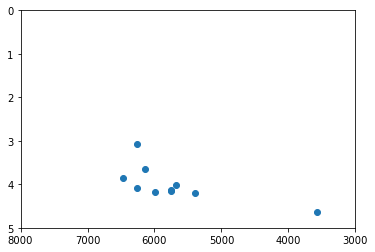

In [3]:


# Get all stars in GALAH DR4 where the sobject_id is in obvious_binaries array
binary_stars = GALAH_DR4[GALAH_DR4['sobject_id'].isin(obvious_binaries['0'].values)]
binary_stars

# Create a random selection of stars, covering the parameter space in teff and logg between 3000 and 8000 K, and 0 and 5 respectively
# This is to test the code with a variety of stars
random_stars = binary_stars.sample(10)
random_stars

plt.figure()
plt.scatter(random_stars['teff'], random_stars['logg'])
plt.xlim(3000, 8000)
plt.ylim(0, 5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(random_stars['sobject_id'].values[0])

In [4]:
import multiprocessing
import stellarmodel
importlib.reload(stellarmodel)
importlib.reload(af)
from stellarmodel import StellarModel

def normalize_parameters(params, bounds):
    normalized_params = [(p - lb) / (ub - lb) for p, (lb, ub) in zip(params, bounds)]
    return normalized_params

def denormalize_parameters(normalized_params, bounds):
    denormalized_params = [lb + n * (ub - lb) for n, (lb, ub) in zip(normalized_params, bounds)]
    return denormalized_params


# Global variable to store the previous parameter values
previous_params = None

# Define the callback function
def track_step_size(current_params):
    global previous_params
    if previous_params is not None:
        step_size = np.linalg.norm(current_params - previous_params)
        print(f"Step size between iterations: {step_size}")
    previous_params = np.copy(current_params)

def fit_model(sobject_id):
    # sobject_id = 140116004301399
    sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
    if sobject_data.size == 0:
        print('No data for sobject_id in GALAH DR4: ', sobject_id)
        return

    tmass_id = sobject_data['tmass_id'].values[0]

    spectrum = af.read_spectrum(sobject_id, tmass_id)
    if spectrum == False:
        return

    same_fe_h = False

    try:
        single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
    except:
        print('Single results not available')
        return

    # model = StellarModel(labels = ['teff', 'logg', 'rv', 'fe_h', 'vmic', 'vsini']) # Model with no interpolation
    model = StellarModel(id=sobject_id, labels = ['mass', 'age', 'metallicity', 'rv', 'fe_h', 'vmic', 'vsini'], fixed_labels=['age', 'metallicity'], interpolator=isochrone_interpolator, interpolate_flux=True) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)


    model.bounds['f_contr'] = (0, 1)

    # Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
    model.set_bounds('teff', (3, 8))
    model.set_bounds('logg', (0.0, 5.0))
    model.set_bounds('fe_h', (-4.0, 1.0))
    model.set_bounds('vmic', (0, 4))
    model.set_bounds('vsini', (0, 30))

    age_min = (10**isochrone_table['logAge'].min()) / 1e9
    age_max = (10**isochrone_table['logAge'].max()) / 1e9

    model.set_bounds('age', (age_min, age_max))
    model.set_bounds('mass', (isochrone_table['mass'].min(), isochrone_table['mass'].max()))
    model.set_bounds('metallicity', (isochrone_table['m_h'].min(), isochrone_table['m_h'].max()))
    model.set_bounds('logL', (isochrone_table['logL'].min(), isochrone_table['logL'].max()))

    model.params['f_contr'] = 0.5


    model.params['rv_1'] = single_results['rv_gauss'][0]
    model.params['rv_2'] = single_results['rv_peak_2'][0]
    if np.isnan(model.params['rv_2']):
        return

    min_rv = min(model.params['rv_1'], model.params['rv_2']) - 100
    max_rv = max(model.params['rv_1'], model.params['rv_2']) + 100
    model.set_bounds('rv', (min_rv, max_rv))

    model.set_param('teff', single_results['teff'][0]/1000.)
    model.set_param('logg', single_results['logg'][0])

    model.set_param('age', sobject_data['age'].values[0].clip(age_min, age_max))
    model.set_param('mass', sobject_data['mass'].values[0])
    model.set_param('metallicity', sobject_data['fe_h'].values[0]) # Approximate m_h as fe_h

    model.set_param('fe_h', single_results['fe_h'][0])
    model.set_param('vmic', 1.5)
    model.set_param('vsini', 4.0)

    print(model.get_params())
    # print(
    #     model.get_params(values_only=False, exclude_fixed=True),
    #       "\n",
    #     model.get_params(values_only=True, exclude_fixed=True),
    #     # model.get_params(values_only=True, exclude_fixed=False)
    # )


fit_model(140116004301399)

{'f_contr': 0.5, 'mass_1': 1.0135012, 'age_1': 6.371642112731934, 'metallicity_1': -0.5258811, 'rv_1': 55.122566, 'fe_h_1': -0.61395806, 'vmic_1': 1.5, 'vsini_1': 4.0, 'mass_2': 1.0135012, 'age_2': 6.371642112731934, 'metallicity_2': -0.5258811, 'rv_2': -52.0, 'fe_h_2': -0.61395806, 'vmic_2': 1.5, 'vsini_2': 4.0, 'teff_1': 6.2633642578125, 'teff_2': 6.2633642578125, 'logg_1': 4.163184, 'logg_2': 4.163184, 'logl_1': 0, 'logl_2': 0}


fitting with rvs:  -46.040802 78.0 140114004201335
Initial parameters:
{'f_contr': 0.5, 'mass_1': 1.2034469, 'rv_1': -46.040802, 'vmic_1': 1.5, 'vsini_1': 4.0, 'mass_2': 1.2034469, 'rv_2': 78.0, 'vmic_2': 1.5, 'vsini_2': 4.0, 'FeH': -0.102882996, 'age': 4.733947277069092, 'teff_1': 6.0684658203125, 'teff_2': 6.0684658203125, 'logg_1': 4.0822406, 'logg_2': 4.0822406, 'logl_1': 0, 'logl_2': 0}
Initial interpolated parameters:
{'f_contr': 0.5, 'mass_1': 1.2034469, 'rv_1': -46.040802, 'vmic_1': 1.5, 'vsini_1': 4.0, 'mass_2': 1.2034469, 'rv_2': 78.0, 'vmic_2': 1.5, 'vsini_2': 4.0, 'FeH': -0.102882996, 'age': 4.733947277069092, 'teff_1': 6.244570030153267, 'teff_2': 6.244570030153267, 'logg_1': 4.220487401589982, 'logg_2': 4.220487401589982, 'logl_1': 0.39381073656167337, 'logl_2': 0.39381073656167337}
Initial bounds:
{'f_contr': (0, 1), 'mass_1': (0.0, 350.0009765625), 'rv_1': (-146.04080200195312, 178.0), 'vmic_1': (0, 4), 'vsini_1': (0, 30), 'mass_2': (0.0, 350.0009765625), 'rv_2': (-146.

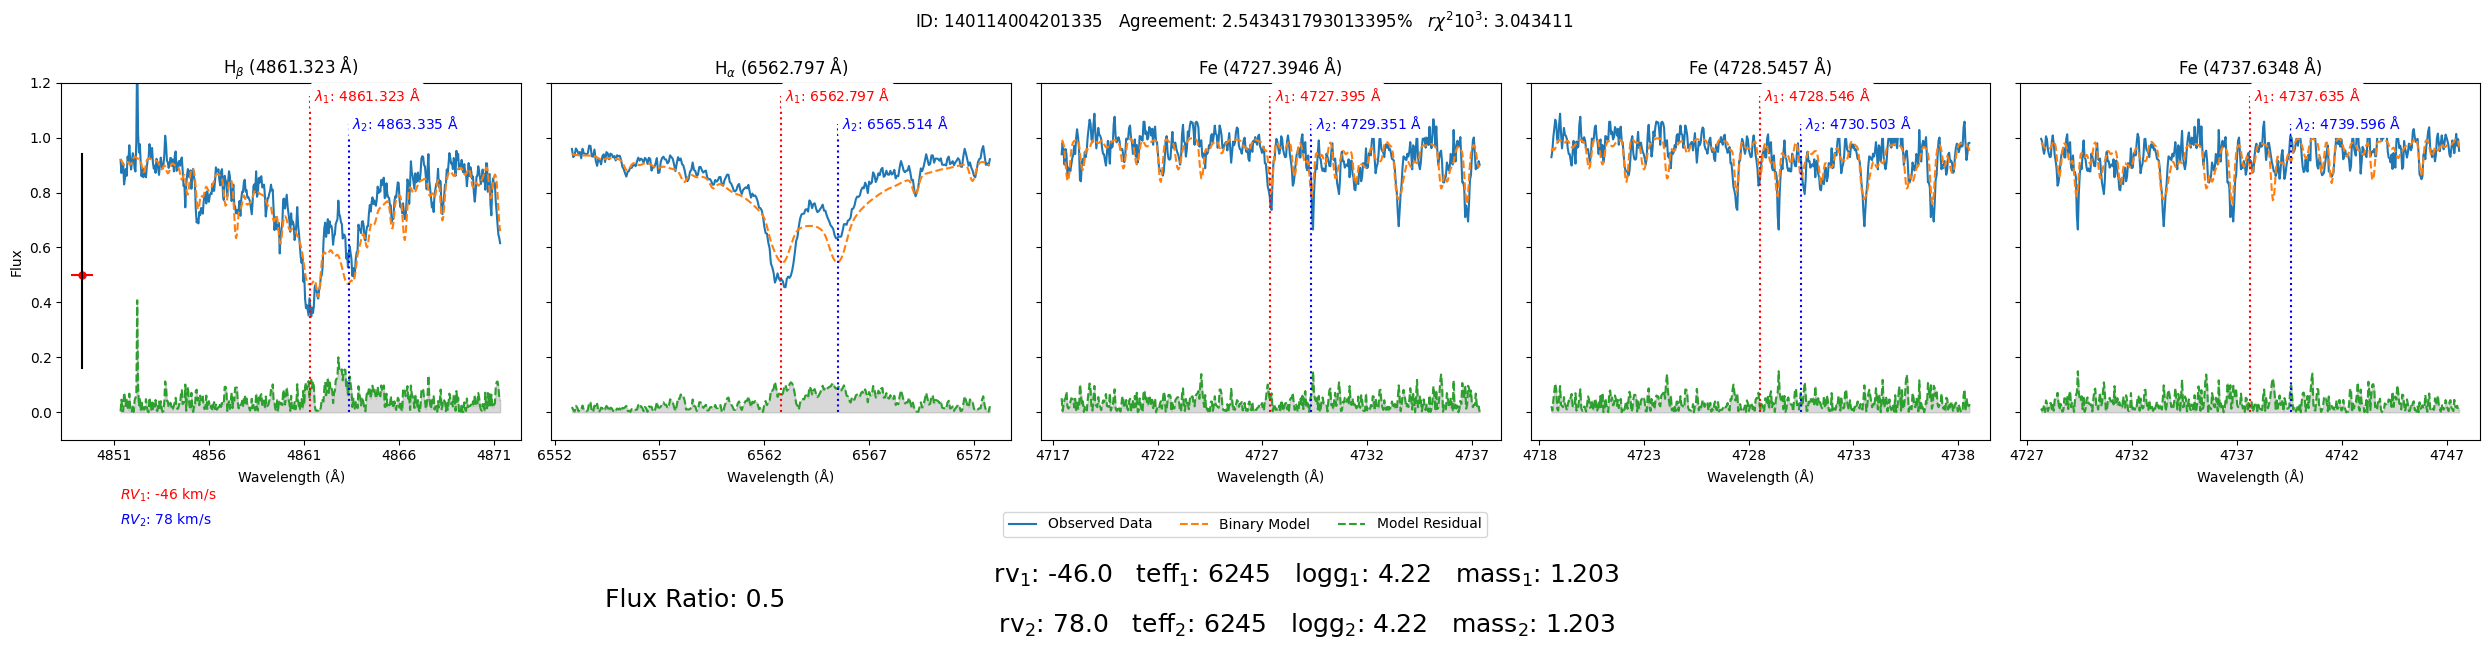

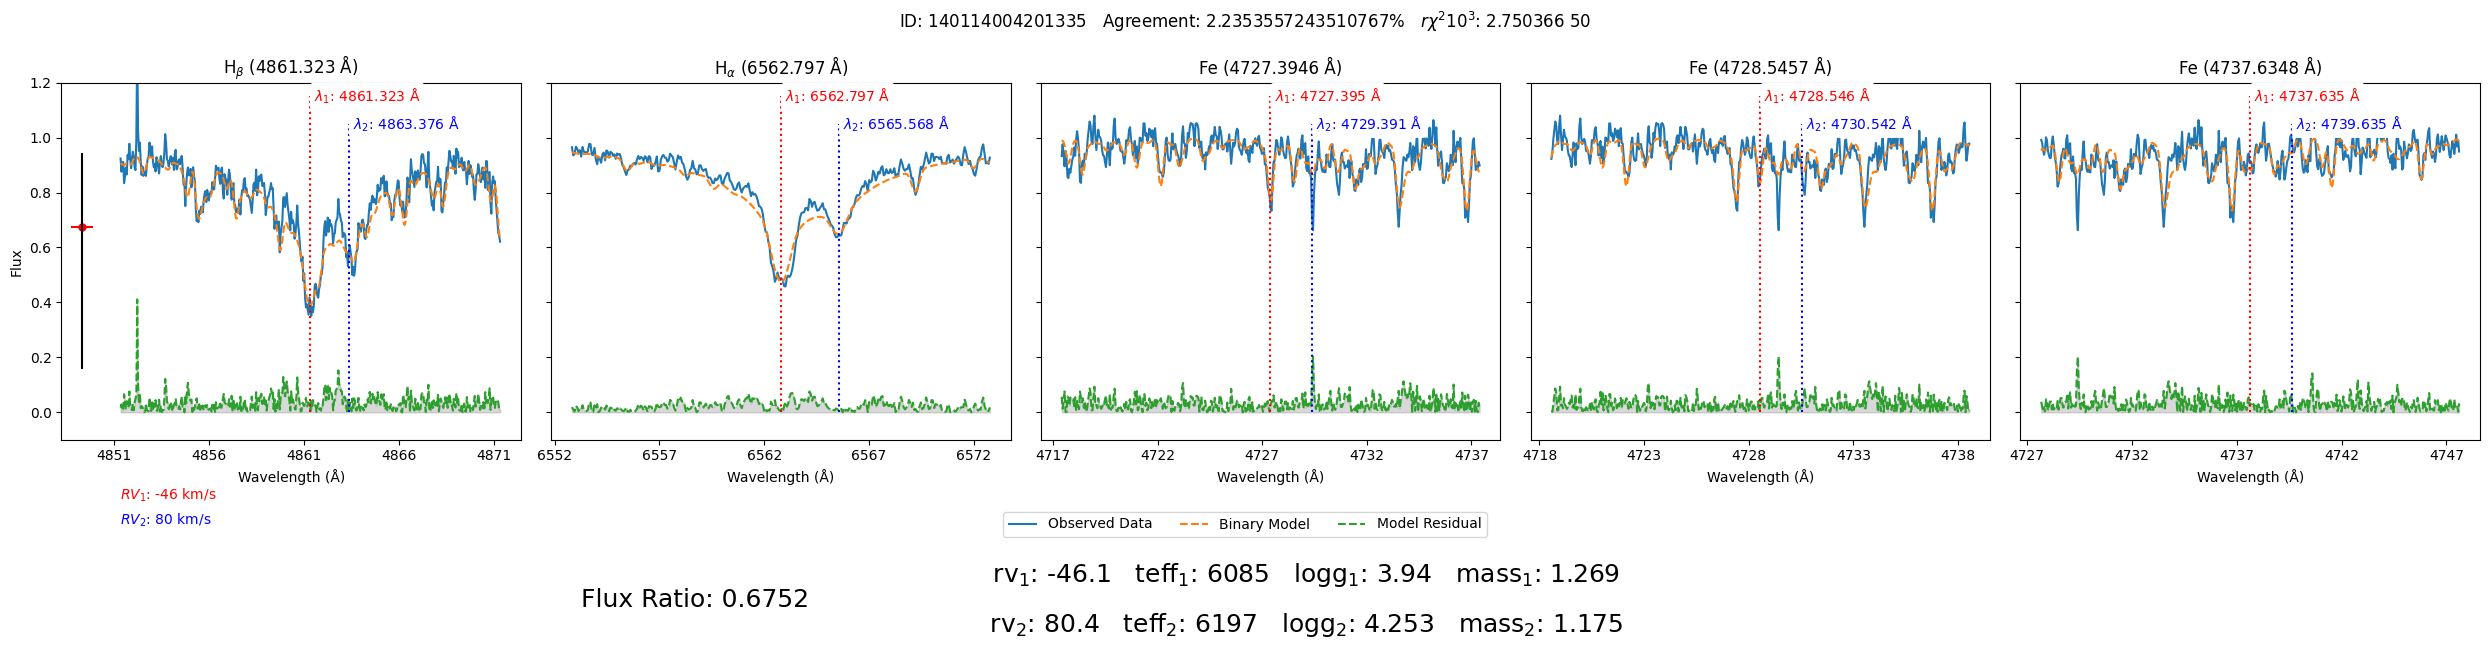

50 {'f_contr': 0.6751938785912719, 'mass_1': 1.269087731407081, 'rv_1': -46.1261681043198, 'vmic_1': 1.533507927029119, 'vsini_1': 10.84204242090992, 'mass_2': 1.1746834224110771, 'rv_2': 80.41528262566435, 'vmic_2': 1.022782648046067, 'vsini_2': 8.446994966729214, 'FeH': -0.10876548665758332, 'age': 5.029805090544451, 'teff_1': 6.084718313381593, 'teff_2': 6.197417389898299, 'logg_1': 3.9397706585629777, 'logg_2': 4.252927656751632, 'logl_1': 0.654154795215413, 'logl_2': 0.33635050446929954}


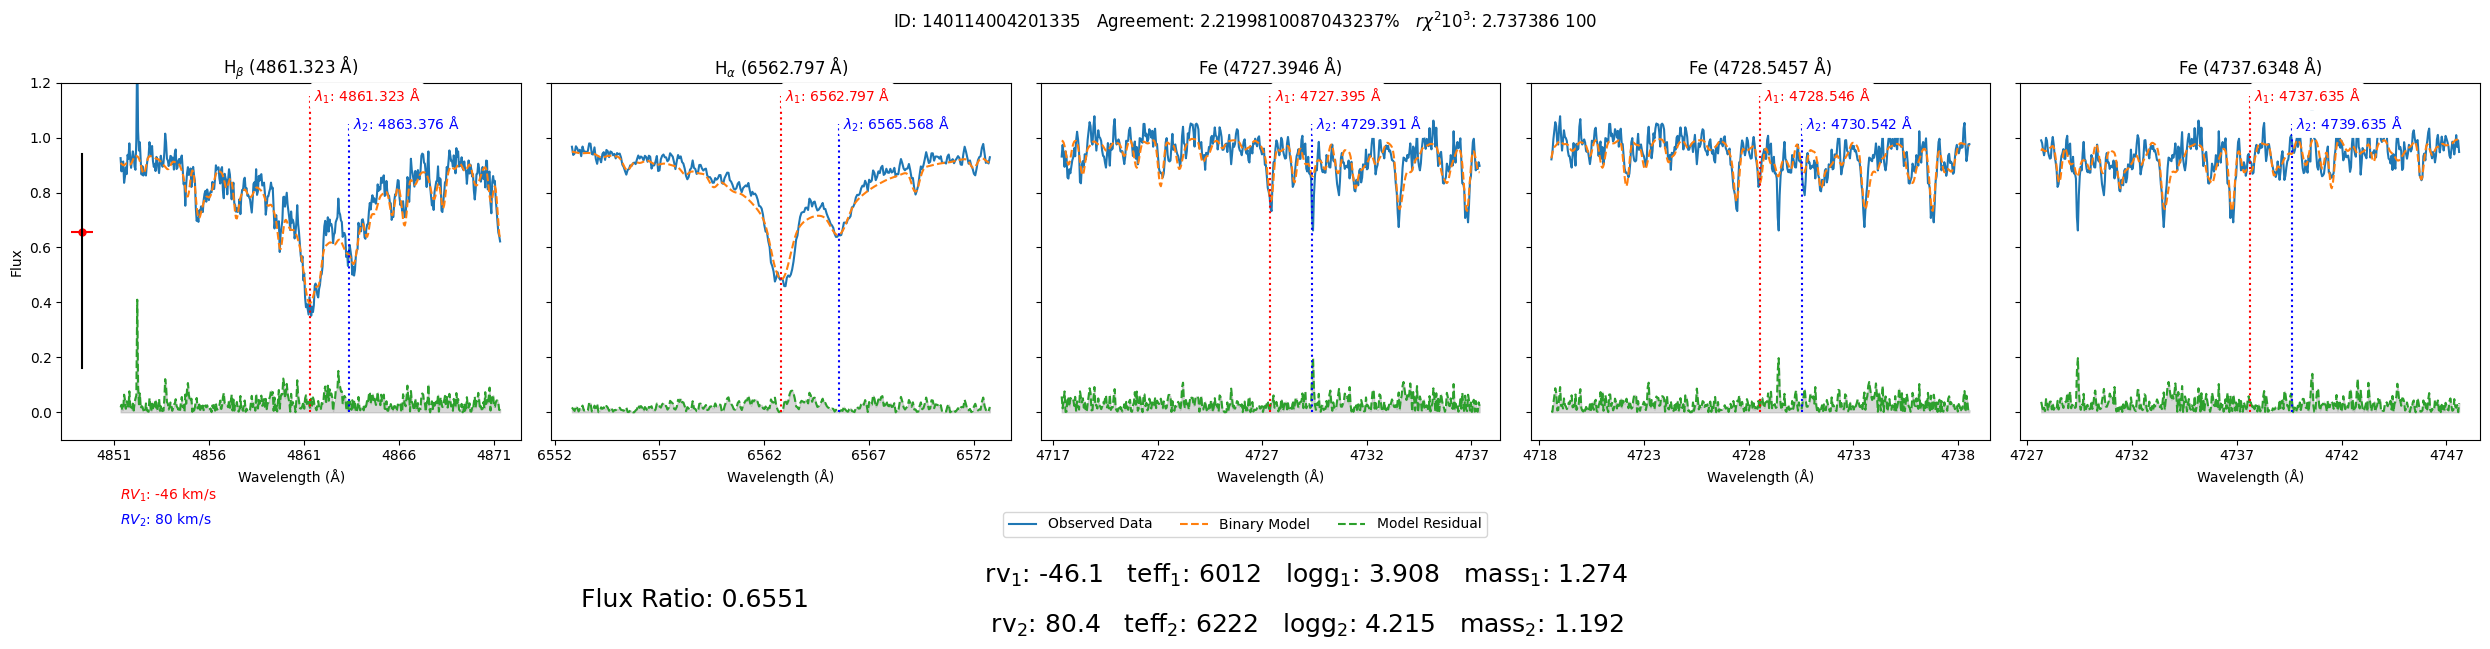

100 {'f_contr': 0.6551381514488166, 'mass_1': 1.2738959261643776, 'rv_1': -46.12618452597569, 'vmic_1': 1.5335070586348052, 'vsini_1': 10.842047528009884, 'mass_2': 1.1922082610350755, 'rv_2': 80.41538276636732, 'vmic_2': 1.0227893064320506, 'vsini_2': 8.446992755917142, 'FeH': -0.10874613480345788, 'age': 5.0298194886922625, 'teff_1': 6.01197904006306, 'teff_2': 6.222046142117883, 'logg_1': 3.9075042857377214, 'logg_2': 4.215197981702657, 'logl_1': 0.6674081720974518, 'logl_2': 0.38872043293945735}
Good curve fit. Updating bounds and initial parameters
Resricted bounds
[(0.5206406056544419, 0.7809609084816629), (0.0029134688000979868, 0.00437020320014698), (0.24667166509298447, 0.3700074976394767), (0.30670146027611855, 0.4600521904141779), (0.28912131148747167, 0.43368196723120744), (0.002733287687031279, 0.004099931530546919), (0.5590808417647889, 0.8386212626471833), (0.20455862088981255, 0.3068379313347188), (0.22525310457497089, 0.3378796568624563), (0.6226021451011758, 0.9339032

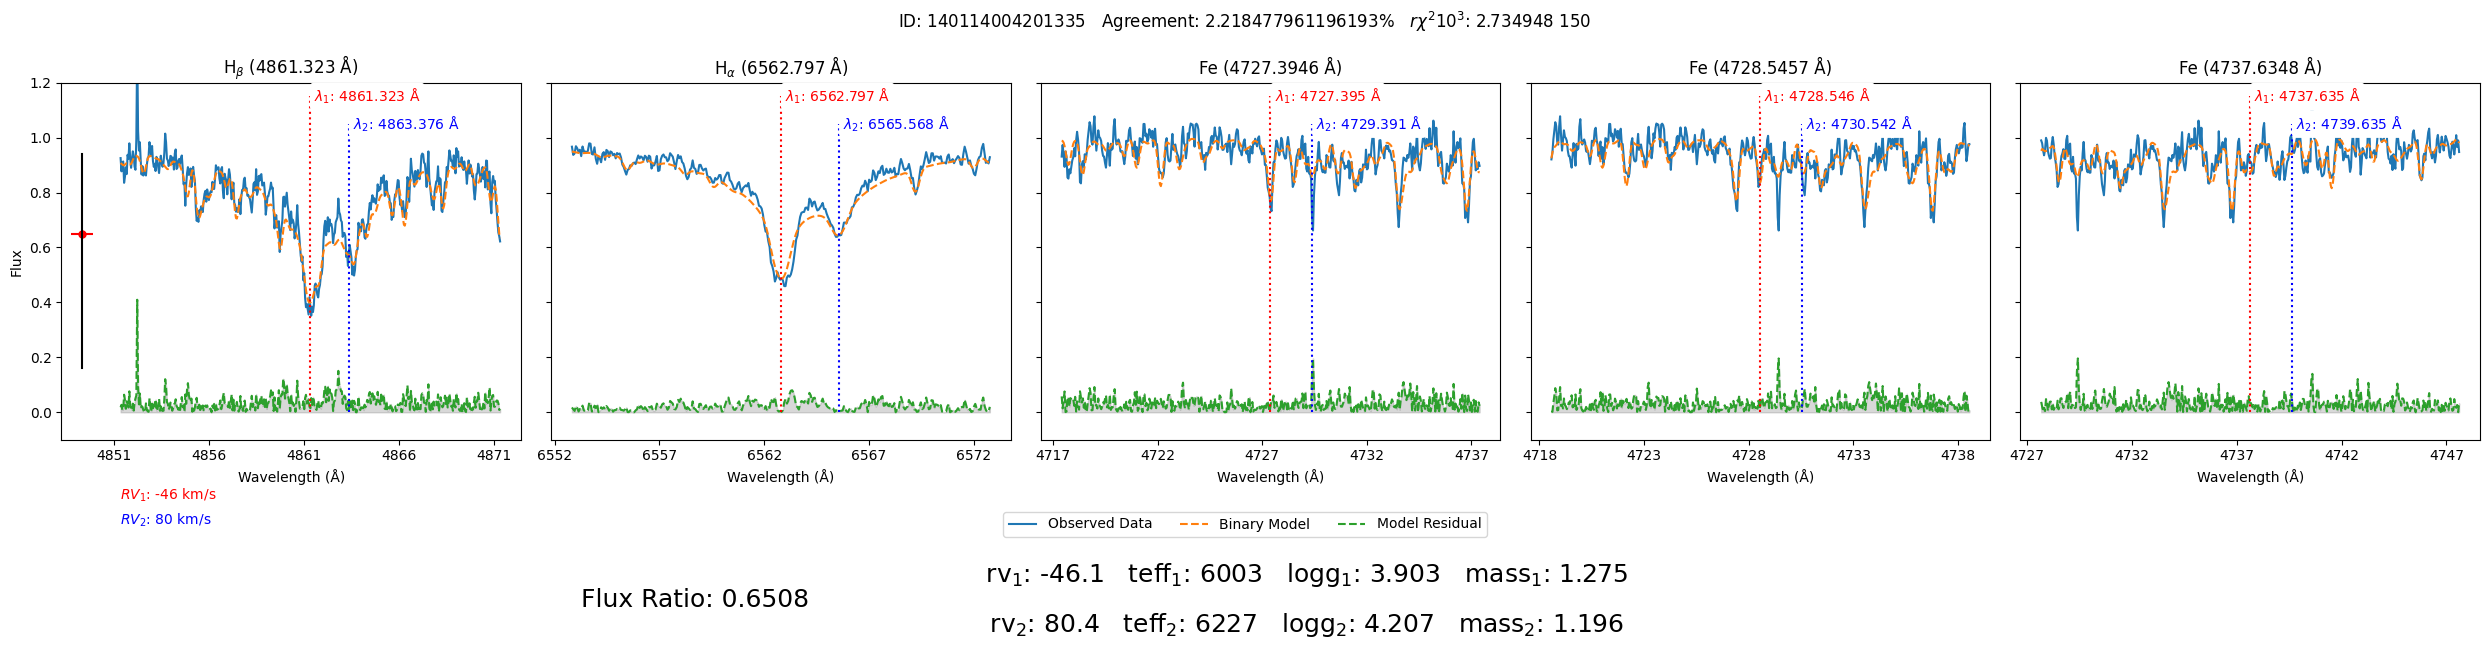

150 {'f_contr': 0.6508007570680523, 'mass_1': 1.274646156523338, 'rv_1': -46.12619676709329, 'vmic_1': 1.5335073013805929, 'vsini_1': 10.842349180780188, 'mass_2': 1.1958166996090058, 'rv_2': 80.41545343478342, 'vmic_2': 1.0227931044490628, 'vsini_2': 8.446991421561409, 'FeH': -0.10873659311765138, 'age': 5.029834231822294, 'teff_1': 6.0029549637757365, 'teff_2': 6.2273969841427315, 'logg_1': 3.9028600178540107, 'logg_2': 4.20663818939722, 'logl_1': 0.6697311005770383, 'logl_2': 0.3993563445818285}
Error in interpolation.
Recieved values:  1.4295753878280055 9.703706869088611 -0.11350375120826772
Error in interpolation.
Recieved values:  1.4295753878280055 9.703706869088611 -0.11350375120826772
Error in interpolation.
Recieved values:  1.4295753878280055 9.703706869088611 -0.11350375120826772
Error in interpolation.
Recieved values:  1.4295753878280055 9.703706869088611 -0.11350375120826772
Error in interpolation.
Recieved values:  1.4260753780623807 9.703706869088611 -0.11350375120826

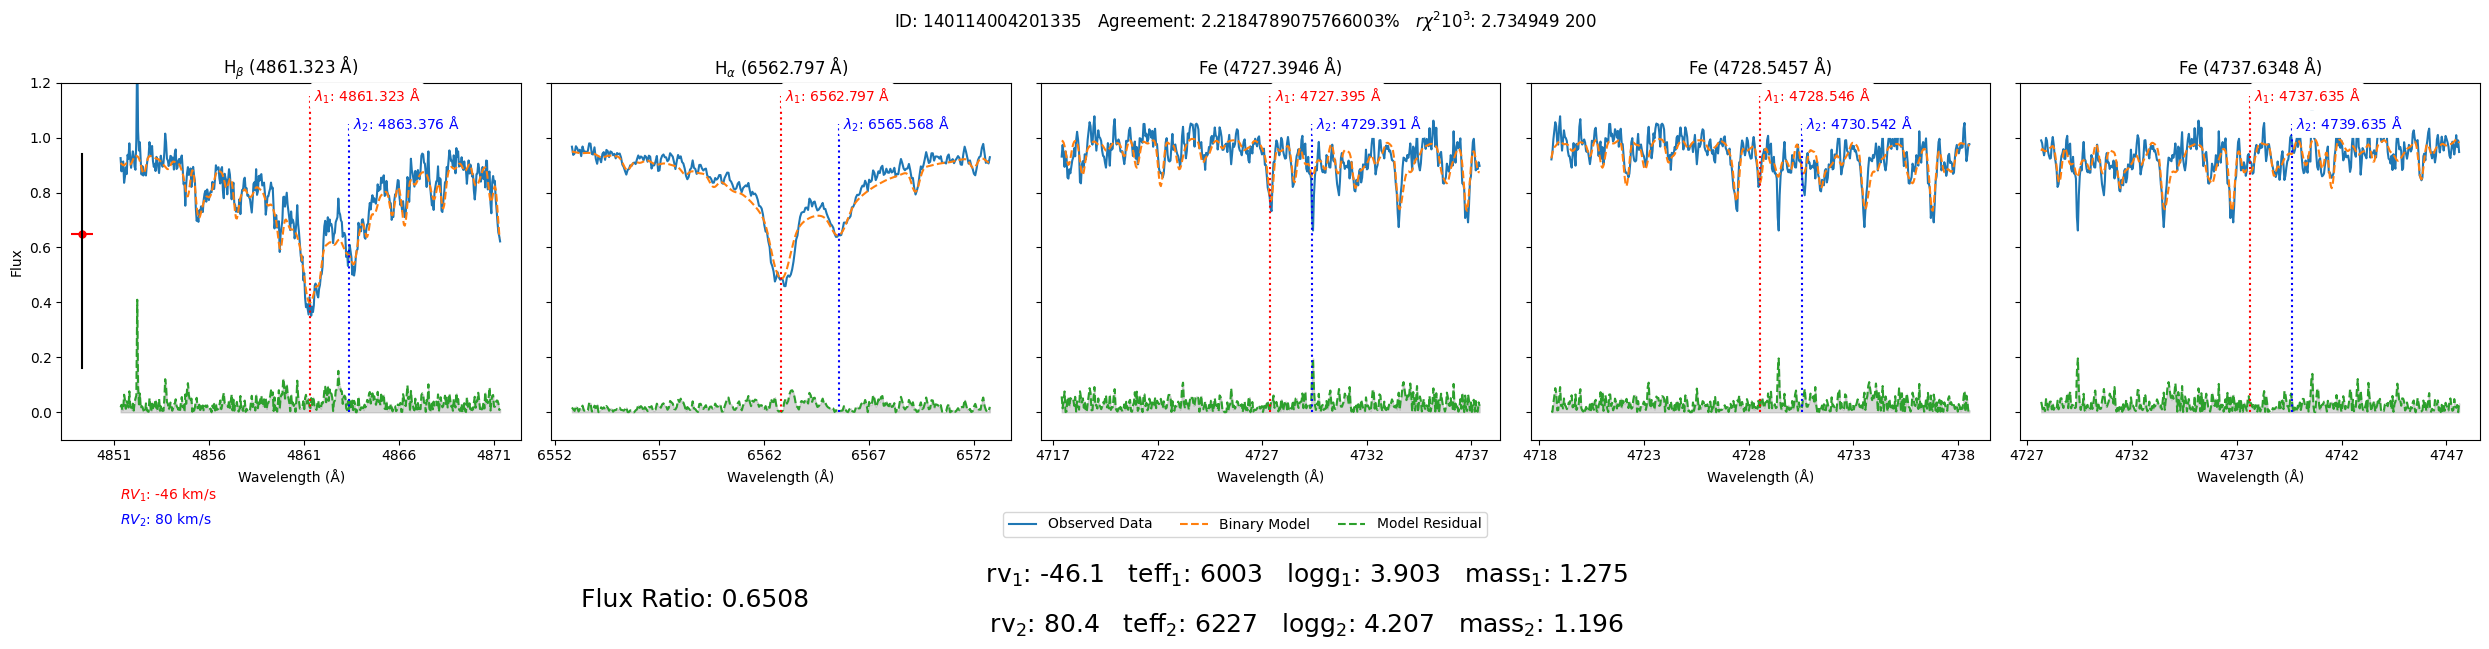

200 {'f_contr': 0.6508007570680523, 'mass_1': 1.274646156523338, 'rv_1': -46.12619676709329, 'vmic_1': 1.5335073013805929, 'vsini_1': 10.842049180780187, 'mass_2': 1.1958166996090058, 'rv_2': 80.41545343478342, 'vmic_2': 1.0227931044490628, 'vsini_2': 8.446991421561409, 'FeH': -0.10873659311765138, 'age': 5.029834231822294, 'teff_1': 6.0029549637757365, 'teff_2': 6.2273969841427315, 'logg_1': 3.9028600178540107, 'logg_2': 4.20663818939722, 'logl_1': 0.6697311005770383, 'logl_2': 0.3993563445818285}


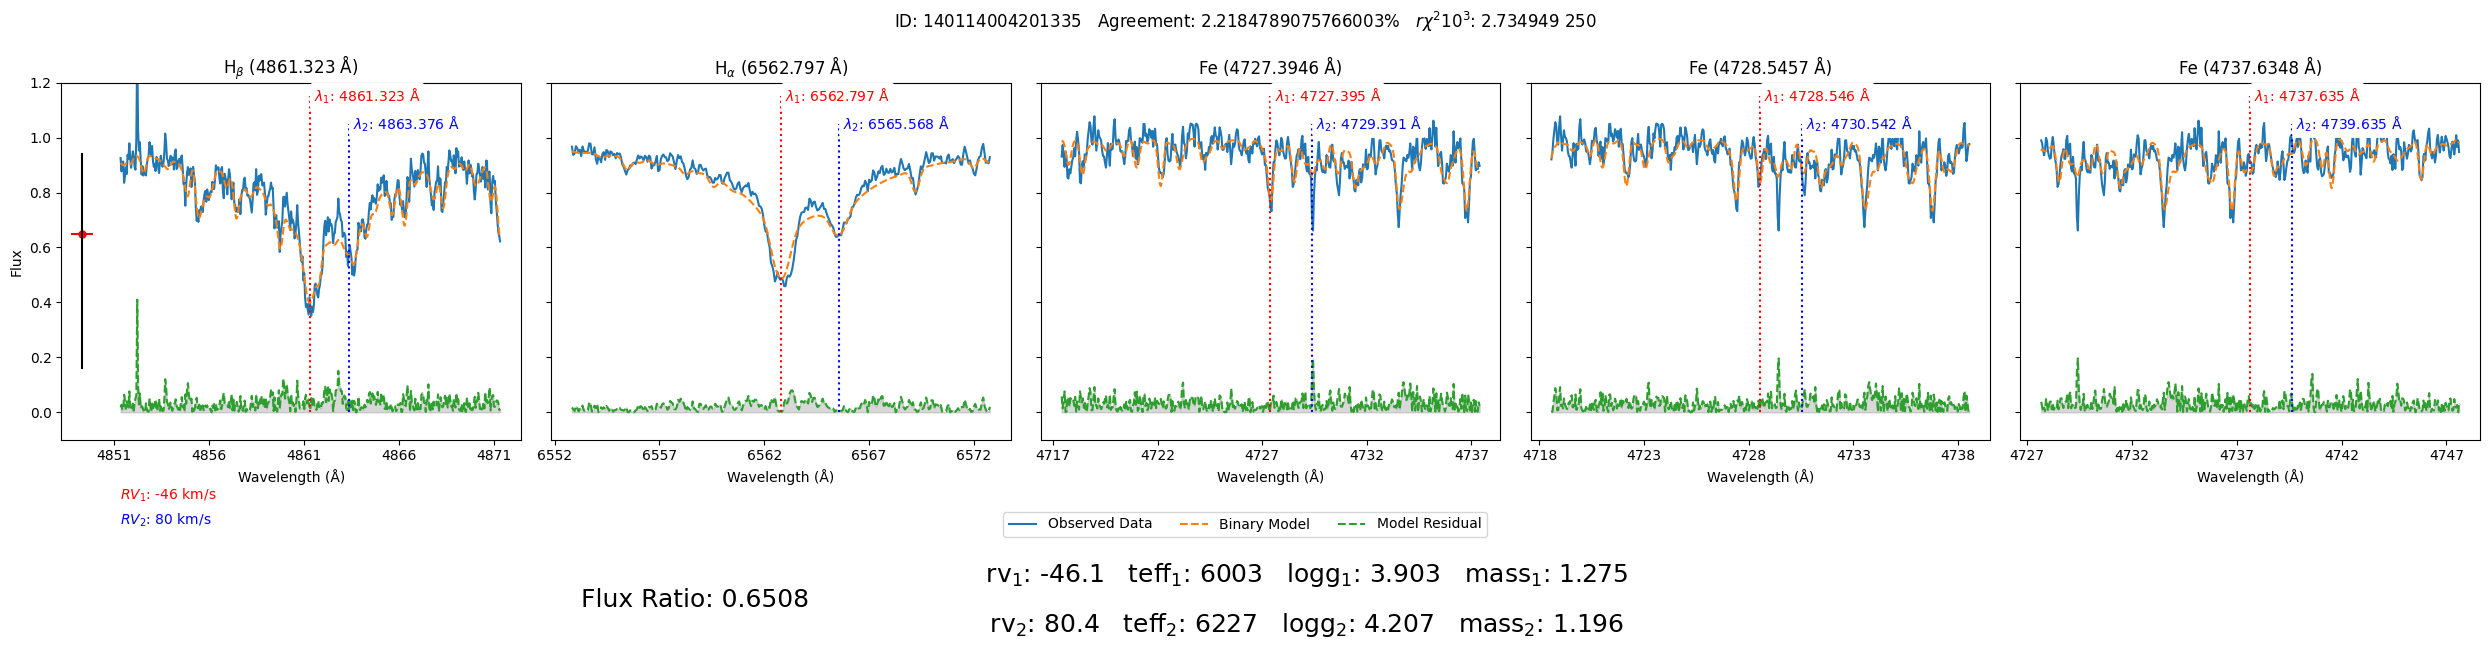

250 {'f_contr': 0.6508007570680523, 'mass_1': 1.274646156523338, 'rv_1': -46.12619676709329, 'vmic_1': 1.5335073013805929, 'vsini_1': 10.842049180780187, 'mass_2': 1.1958166996090058, 'rv_2': 80.41545343478342, 'vmic_2': 1.0227931044490628, 'vsini_2': 8.446991421561409, 'FeH': -0.10873659311765138, 'age': 5.029834231822294, 'teff_1': 6.0029549637757365, 'teff_2': 6.2273969841427315, 'logg_1': 3.9028600178540107, 'logg_2': 4.20663818939722, 'logl_1': 0.6697311005770383, 'logl_2': 0.3993563445818285}


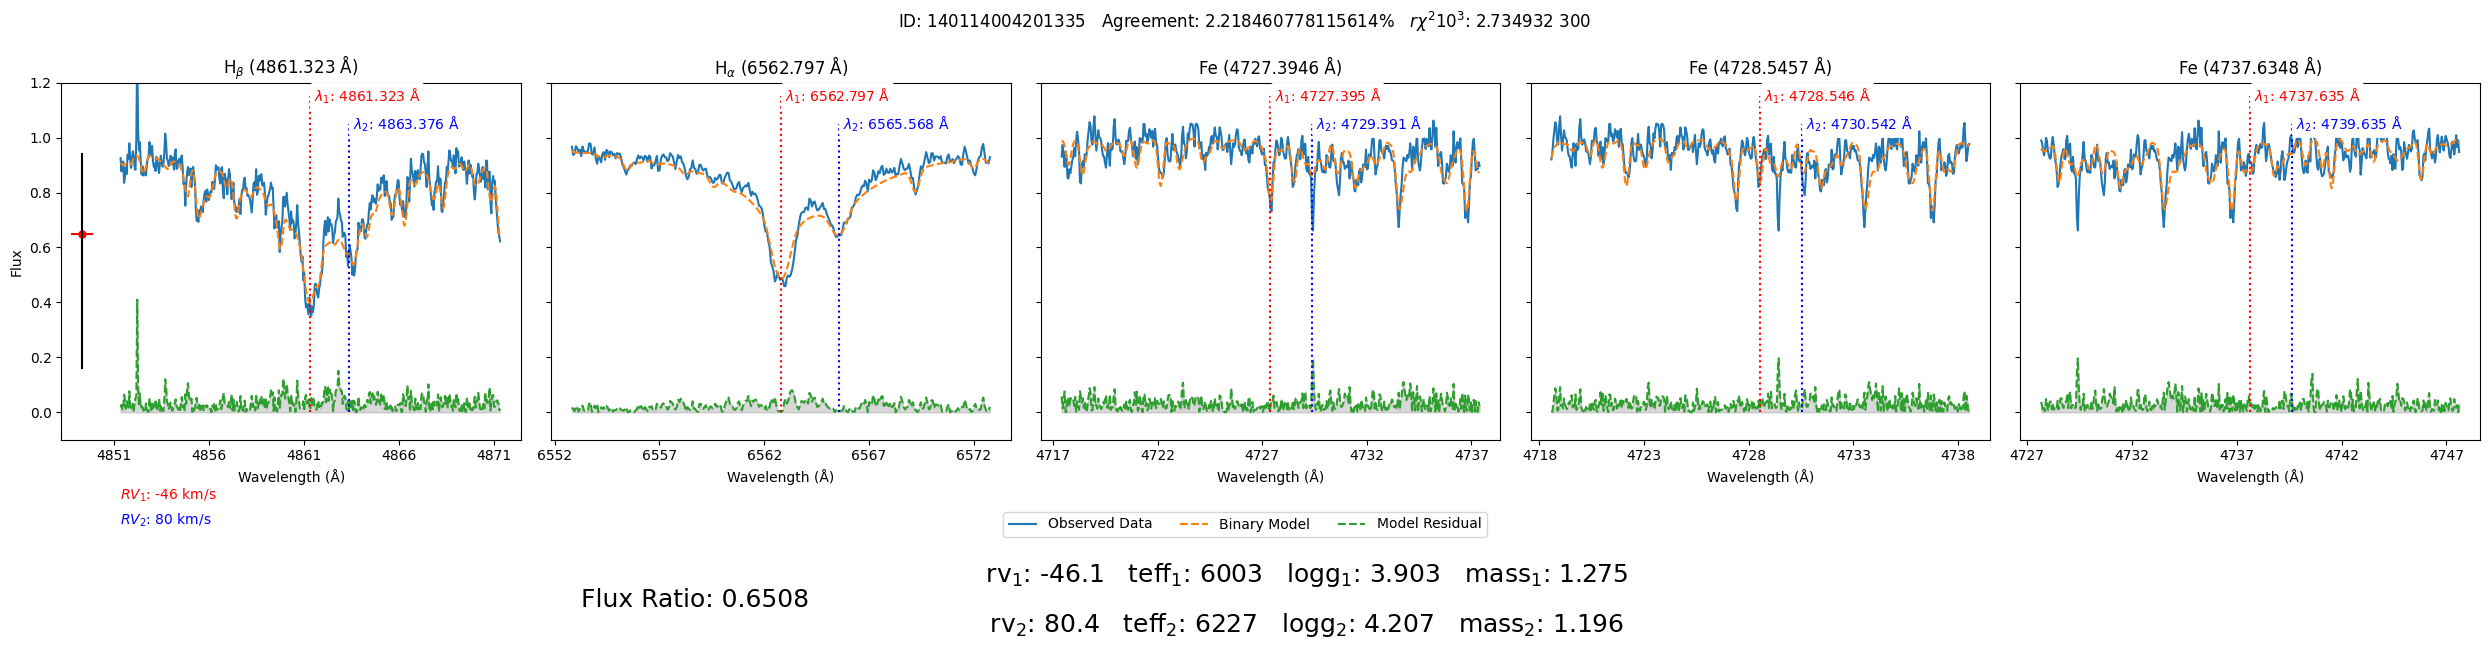

300 {'f_contr': 0.6508021569688085, 'mass_1': 1.2746461565233385, 'rv_1': -46.12619676709329, 'vmic_1': 1.5335073013805929, 'vsini_1': 10.842049180780187, 'mass_2': 1.195816699609006, 'rv_2': 80.41545343478342, 'vmic_2': 1.0227931044490628, 'vsini_2': 8.446991421561409, 'FeH': -0.10873659311765138, 'age': 5.029982173316234, 'teff_1': 6.002829381202423, 'teff_2': 6.227390920961872, 'logg_1': 3.902808417501528, 'logg_2': 4.206623565588939, 'logl_1': 0.6697466818511633, 'logl_2': 0.3993692506290708}


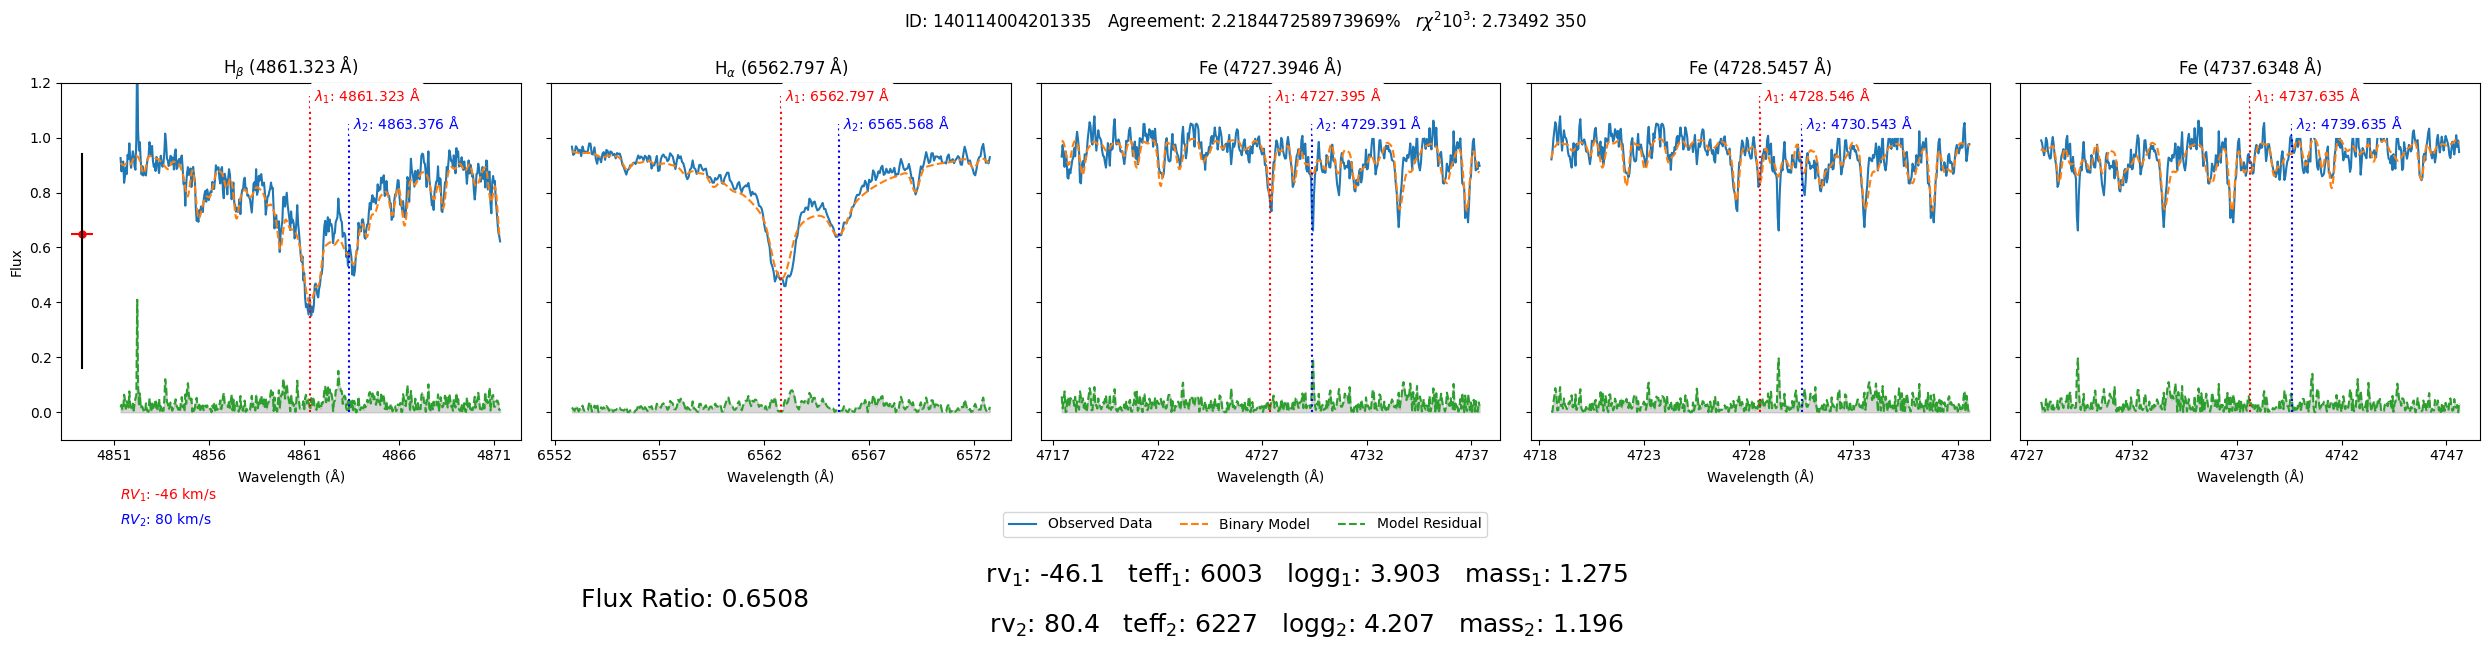

350 {'f_contr': 0.6508007570680523, 'mass_1': 1.274646156523338, 'rv_1': -46.12619676709329, 'vmic_1': 1.5335073013805929, 'vsini_1': 10.842049180780187, 'mass_2': 1.1958166996090058, 'rv_2': 80.41869384280344, 'vmic_2': 1.0227931044490628, 'vsini_2': 8.446991421561409, 'FeH': -0.10873659311765138, 'age': 5.029834231822294, 'teff_1': 6.0029549637757365, 'teff_2': 6.2273969841427315, 'logg_1': 3.9028600178540107, 'logg_2': 4.20663818939722, 'logl_1': 0.6697311005770383, 'logl_2': 0.3993563445818285}
L-BFGS-B results:
{'f_contr': 0.6508007570680526, 'mass_1': 1.2746461565233382, 'rv_1': -46.12619676709329, 'vmic_1': 1.5335073013805929, 'vsini_1': 10.842049180780187, 'mass_2': 1.1958166996090058, 'rv_2': 80.41545343478342, 'vmic_2': 1.0227931044490628, 'vsini_2': 8.446991421561409, 'FeH': -0.10873659311765138, 'age': 5.029834231822294, 'teff_1': 6.00295496377573, 'teff_2': 6.2273969841427315, 'logg_1': 3.9028600178540094, 'logg_2': 4.20663818939722, 'logl_1': 0.669731100577039, 'logl_2': 

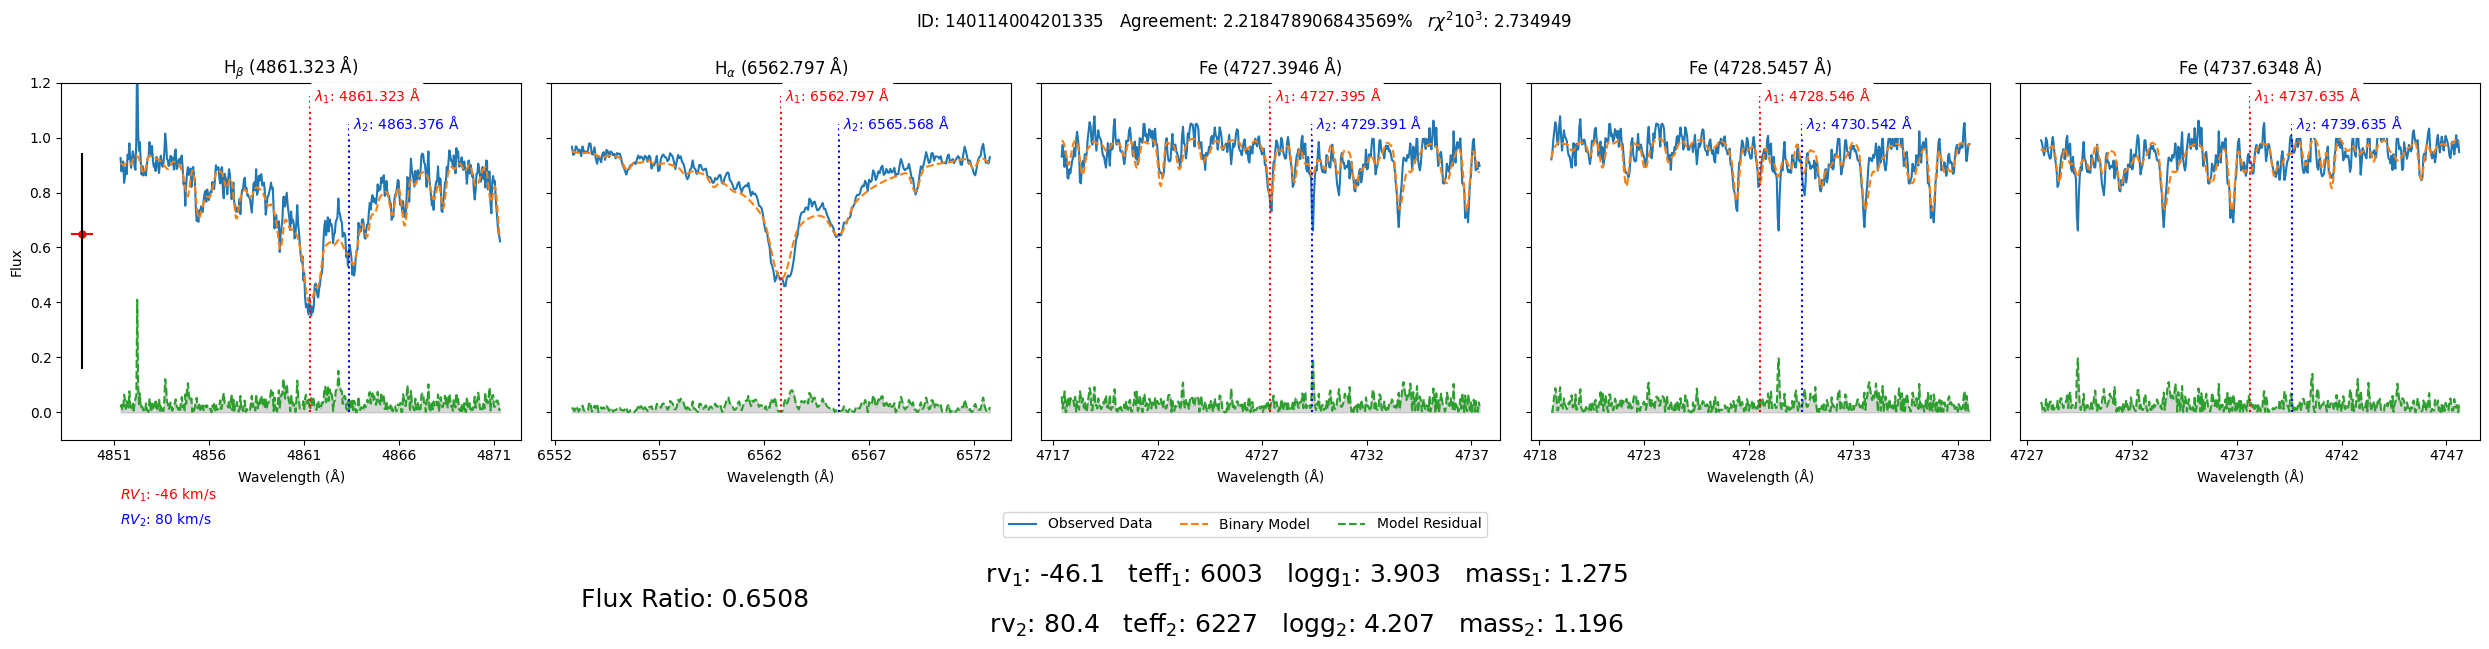

Final parameters:
{'f_contr': 0.6508007570680526, 'mass_1': 1.2746461565233382, 'rv_1': -46.12619676709329, 'vmic_1': 1.5335073013805929, 'vsini_1': 10.842049180780187, 'mass_2': 1.1958166996090058, 'rv_2': 80.41545343478342, 'vmic_2': 1.0227931044490628, 'vsini_2': 8.446991421561409, 'FeH': -0.10873659311765138, 'age': 5.029834231822294, 'teff_1': 6.00295496377573, 'teff_2': 6.2273969841427315, 'logg_1': 3.9028600178540094, 'logg_2': 4.20663818939722, 'logl_1': 0.669731100577039, 'logl_2': 0.3993563445818285}


In [15]:
import multiprocessing
import stellarmodel
importlib.reload(stellarmodel)
importlib.reload(af)
from stellarmodel import StellarModel
from pyswarm import pso

import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.utils.functions import single_obj as fx


single_results = None
particle_tracking = {}
iterations = 0


def normalize_parameters(params, bounds):
    normalized_params = [(p - lb) / (ub - lb) for p, (lb, ub) in zip(params, bounds)]
    return normalized_params

def denormalize_parameters(normalized_params, bounds):
    denormalized_params = [lb + n * (ub - lb) for n, (lb, ub) in zip(normalized_params, bounds)]
    return denormalized_params


# Global variable to store the previous parameter values
previous_params = None

# Define the callback function
def track_step_size(current_params):
    global previous_params
    if previous_params is not None:
        step_size = np.linalg.norm(current_params - previous_params)
        print(f"Step size between iterations: {step_size}")
    previous_params = np.copy(current_params)

def fit_model(sobject_id):
    # sobject_id = 140116004301399
    sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
    if sobject_data.size == 0:
        print('No data for sobject_id in GALAH DR4: ', sobject_id)
        return

    tmass_id = sobject_data['tmass_id'].values[0]

    spectrum = af.read_spectrum(sobject_id, tmass_id)
    if spectrum == False:
        return


    try:
        single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
    except:
        print('Single results not available')
        return

    # model = StellarModel(labels = ['teff', 'logg', 'rv', 'fe_h', 'vmic', 'vsini']) # Model with no interpolation
    # model = StellarModel(id=sobject_id, labels = ['mass', 'age', 'metallicity', 'rv', 'fe_h', 'vmic', 'vsini'], interpolator=isochrone_interpolator, interpolate_flux=True) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)
    
    # model = StellarModel(
    #             id=sobject_id, 
    #             labels = ['mass', 'rv', 'vmic', 'vsini', 'FeH', 'age'], 
    #             # fixed_labels=['FeH'], # These are parameters that exist, but we don't fit for. They are used as is or are outputs of the interpolation?
    #             # single_labels=['FeH', 'age'], # These are parameters that are the same for both components
    #             interpolator=isochrone_interpolator, 
    #             interpolate_flux=True,
    #             same_fe_h=False
    #         ) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)

    # Interpolation
    # model = StellarModel(
    #             id=sobject_id, 
    #             labels = ['mass', 'rv', 'vmic', 'vsini'], 
    #             # fixed_labels=['FeH'], # These are parameters that exist, but we don't fit for. They are used as is or are outputs of the interpolation?
    #             single_labels=['FeH', 'age'], # These are parameters that are the same for both components
    #             interpolator=isochrone_interpolator, 
    #             interpolate_flux=True,
    #             same_fe_h=True
    #         ) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)

    # Trilinear Interpolation
    model = StellarModel(
                id=sobject_id, 
                labels = ['mass', 'rv', 'vmic', 'vsini'], 
                # fixed_labels=['FeH'], # These are parameters that exist, but we don't fit for. They are used as is or are outputs of the interpolation?
                single_labels=['FeH', 'age'], # These are parameters that are the same for both components
                interpolator='trilinear', 
                interpolate_flux=True,
                same_fe_h=True
            ) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)
    

    model.bounds['f_contr'] = (0, 1)

    # Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
    model.set_bounds('teff', (3, 8))
    model.set_bounds('logg', (0.0, 5.0))
    model.set_bounds('vmic', (0, 4))
    model.set_bounds('vsini', (0, 30))

    age_min = (10**isochrone_table['logAge'].min()) / 1e9
    age_max = (10**isochrone_table['logAge'].max()) / 1e9

    model.set_bounds('FeH', (-4.0, 1.0))
    model.set_bounds('age', (age_min, age_max))

    try:
        model.set_bounds('mass', (isochrone_table['mass'].min(), isochrone_table['mass'].max()))
    except:
        model.set_bounds('mass', (isochrone_table['mini'].min(), isochrone_table['mini'].max()))


    # model.set_bounds('metallicity', (isochrone_table['m_h'].min(), isochrone_table['m_h'].max()))
    model.set_bounds('logl', (isochrone_table['logL'].min(), isochrone_table['logL'].max()))

    model.params['f_contr'] = 0.5


    model.params['rv_1'] = single_results['rv_gauss'][0]
    model.params['rv_2'] = single_results['rv_peak_2'][0]
    if np.isnan(model.params['rv_2']):
        return

    min_rv = min(model.params['rv_1'], model.params['rv_2']) - 100
    max_rv = max(model.params['rv_1'], model.params['rv_2']) + 100
    model.set_bounds('rv', (min_rv, max_rv))

    model.set_param('teff', single_results['teff'][0]/1000.)

    model.set_param('logg', single_results['logg'][0])

    # Set the parameters required for the interpolation
    model.set_param('mass', sobject_data['mass'].values[0])
    model.set_param('age', sobject_data['age'].values[0].clip(age_min, age_max))

    model.set_param('FeH', sobject_data['fe_h'].values[0])
    model.set_param('vmic', 1.5)
    model.set_param('vsini', 4.0)

    af.load_neural_network(spectrum)
    af.set_iterations(0)
    af.load_dr3_lines()

    print("fitting with rvs: ", model.params['rv_1'], model.params['rv_2'], sobject_id)



    # Generate an initial model with the starting parameters
    print("Initial parameters:")
    print(model.get_params(values_only=False, exclude_fixed=True))
    print("Initial interpolated parameters:")
    model.interpolate()
    print(model.get_params(values_only=False, exclude_fixed=True))
    # print(model.)
    # print(model.fixed_labels)

    print("Initial bounds:")
    print(model.bounds)


    if len(model.get_params(values_only=True, exclude_fixed=True)) != len(model.bounds):
        print("Length of parameters and bounds do not match")
        # Print out which parameters don't have bounds
        for p in model.get_params(values_only=False, exclude_fixed=True):
            if p not in model.bounds:
                print("Missing: ", p)
        return



    wave_init, data_init, sigma2_init, model_init, unmasked_init = af.return_wave_data_sigma_model(model, spectrum, model.same_fe_h)
    unmasked = unmasked_init

    # Produce a plot with the initial parameters
    model.generate_model(spectrum)
    model.plot()



    iterations = 0
    def objective_function_norm(normalized_params):

        global previous_params
        global iterations
        show_plot = False
        residuals_list = []

        # If this is LBFGS-B, there is only a single particle. If PSO we need to iterate over all particles
        if isinstance(normalized_params[0], (list, np.ndarray)):
            show_plot = False
            normalized_params_list = normalized_params
        else:
            show_plot = True
            normalized_params_list = [normalized_params]

        # Note we pass in normalized parameters. We need to denormalize them before passing them to the model
        for i, particle_params in enumerate(normalized_params_list):

            # Denormalize the parameters
            model_parameters = denormalize_parameters(particle_params, original_bounds)

            # Calculate the model flux using the current parameters
            model_flux = af.get_flux_only(wave_init, model, spectrum, model.same_fe_h, unmasked, *model_parameters, plot=show_plot)
            
            # Need to generate a model with the current parameters to determine residual
            model.generate_model(spectrum)
            # residuals = model.get_residual()
            residuals = model.get_rchi2()
            residuals_list.append(residuals)

            previous_params = np.copy(particle_params)

            #### Only needed for Nelder-Mead
            # for param, bound in zip( model.get_params(), model.get_bounds()):
            #     if model.params[param] < bound[0] or model.params[param] > bound[1]:
            #         # print(param, model.params[param], bound)
            #         # print(model.get_params())
            #         # print(bounds)
            #         return np.inf

        if show_plot == False:
            best_score = optimizer.swarm.best_cost * 1e3
            if best_score < 1e3: # At t = 0 this is inf
                best_params = optimizer.swarm.best_pos
                best_params = denormalize_parameters(best_params, original_bounds)
                print(f"Global Best Parameters: {best_params}")
                print(f"Global Best Score: {best_score}")

                model.set_params(best_params)
                model.generate_model(spectrum)
                model.plot(title_text=str(iterations))
                iterations += 1

        if len(residuals_list) == 1:
            return residuals_list[0]
        else:
            return residuals_list


        # return residuals
        if len(residuals_list) == 1:
            return residuals_list[0]
        else:
            return residuals_list

    # Fit the model to the data. This takes the model parameters and produces a synthetic spectra using the neural network. It then compares this to the observed data and adjusts the model parameters (and thereby the synthetic spectra from the NN) to minimize the difference between the two.
    kwargs={'maxfev':20000,'xtol':1e-5, 'gtol':1e-5, 'ftol':1e-5}
    model_parameters_iter1, covariances_iter1 = curve_fit(
        lambda wave_init, 
            *model_parameters: af.get_flux_only(wave_init, model, spectrum, model.same_fe_h, unmasked, *model_parameters, plot=True),
        wave_init[unmasked_init],
        data_init[unmasked_init],
        p0=model.get_params(values_only=True, exclude_fixed=True),
        sigma=np.sqrt(sigma2_init[unmasked_init]),
        absolute_sigma=True,
        bounds=model.get_bounds(),
        **kwargs
    )



    # Get the original parameter values and bounds
    original_params = model.get_params(values_only=True)# model_parameters_iter1 # model.get_params(values_only=True)
    original_bounds = model.get_bounds(type='tuple')
    bounds = model.get_bounds(type='tuple')


    # Normalize the initial parameter values
    normalized_x0 = normalize_parameters(original_params, bounds)
    
    # If the curve fit hasn't failed, assume the parameters returned from it are good. 
    # Use these new values to update the bounds for the minimization and as the initial guess for the next optimization.
    if model.get_residual() < 5:
        print("Good curve fit. Updating bounds and initial parameters")
        # Update bounds to so that they are within 50% of the values returned by curve_fit
        margin = 0.2
        bounds = [(max(lb, p - margin * abs(p)), min(ub, p + margin * abs(p)) ) for p, (lb, ub) in zip(normalized_x0, [(0, 1)] * len(bounds))]
        print("Resricted bounds")
        print(bounds)
        # Ensure these new bounds are also within the (0, 1) bounds
        bounds = [(max(0, lb), min(1, ub)) for lb, ub in bounds]
            
    else:
        bounds = [(0, 1)] * len(bounds)
    


    # bounds = [(0, 1)] * len(bounds)
    bounds_dict = {param: bound for param, bound in zip(model.get_params(values_only=False, exclude_fixed=True), bounds)}
    print("Boudns dict")
    print(bounds_dict)
    model.bounds = bounds_dict
    # return

    # Get normalized_x0 as a dict
    normalized_x0_dict = {param: val for param, val in zip(model.get_params(values_only=False, exclude_fixed=True), normalized_x0)}
    print(normalized_x0_dict)



    # lower_bounds = [b[0] for b in bounds]
    # upper_bounds = [b[1] for b in bounds]

    # # Call the pso function
    # best_params, best_score = pso(
    #     objective_function_norm,
    #     lower_bounds,
    #     upper_bounds,
    #     swarmsize=100,        # Number of particles
    #     maxiter=100,          # Number of iterations
    #     minstep=1e-8,         # Minimum step size before convergence
    #     minfunc=1e-8,         # Minimum function change before convergence
    #     debug=True            # Set to True for detailed logging
    # )







    # print("Final bounds:")
    # print(best_params)
    # print(best_score)


    print("Optimizing with L-BFGS-B")
    print(model.get_params())
    print(normalized_x0)
    print(model.get_bounds(type='tuple'))

    #### L-BFGS-B
    result = scipy.optimize.minimize(
        objective_function_norm,
        x0=normalized_x0, #model.get_params(values_only=True),
        method='L-BFGS-B',
        bounds= bounds, #[(0, 1)] * len(bounds), #model.get_bounds(type='tuple'),
        # Ftol is the relative error desired in the sum of squares.
        # Gtol is the gradient norm desired in the sum of squares.
        options={'maxfun': 1000, 'gtol': 1e-10, 'ftol': 1e-10, 'eps': 1e-5}
    )
    ####

    print("L-BFGS-B results:")
    print(model.params)

    # Restrict the bounds a second time
    # bounds = model.get_bounds(type='tuple')
    # normalized_x0 = normalize_parameters(model.get_params(values_only=True), original_bounds)

    # margin = 0.1
    # bounds = [(max(lb, p - margin * abs(p)), min(ub, p + margin * abs(p)) ) for p, (lb, ub) in zip(normalized_x0, [(0, 1)] * len(bounds))]
    # print("Resricted bounds")
    # print(bounds)
    # # Ensure these new bounds are also within the (0, 1) bounds
    # bounds = [(max(0, lb), min(1, ub)) for lb, ub in bounds]


    # NOTE: Pyswarms requires each particle to have its own optimization. We currently optimise one model object, so we need to change this to optimise multiple models.

    # # Define the bounds as arrays
    # lower_bounds = [b[0] for b in bounds]
    # upper_bounds = [b[1] for b in bounds]
    # bounds_array = [lower_bounds, upper_bounds]

    # # print("Bounds array", bounds_array)
    # # return

    # # Define options
    # options = {
    #     'c1': 0.5,  # Cognitive parameter
    #     'c2': 0.3,  # Social parameter
    #     'w': 0.9,   # Inertia weight
    # }

    # # Initialize the optimizer
    # optimizer = ps.single.GlobalBestPSO(
    #     n_particles=100,              # Number of particles
    #     dimensions=len(lower_bounds),       # Dimensionality of the parameter space
    #     options=options,
    #     bounds=bounds_array           # (lower_bounds, upper_bounds)
    # )

    # # Perform optimization
    # best_score, best_params = optimizer.optimize(
    #     objective_function_norm,     # Objective function
    #     iters=200,                   # Number of iterations
    #     verbose=True,                 # Display progress    
    # )

    # # Optionally, plot the cost history
    # plot_cost_history(optimizer.cost_history)
    

    #### Nelder-Mead
    # result = scipy.optimize.minimize(
    #     objective_function_norm,
    #     x0=normalized_x0, #model.get_params(values_only=True),
    #     method='Nelder-Mead',
    #     # Ftol is the relative error desired in the sum of squares.
    #     # Gtol is the gradient norm desired in the sum of squares.
    #     options={'maxfun': 10000, 'fatol': 1e-10, 'xatol': 1e-5, 'disp': True}, #, ,
    #     callback=track_step_size  # Pass the callback function 
    # )
    ####

    # print("Denomralised")
    # print(denormalize_parameters(best_params, original_bounds))
    
    # final_params = denormalize_parameters(best_params, original_bounds)

    # for i, param in enumerate(model.get_params(values_only=False)):
    #     model.params[param] = final_params[i]

    model.plot()
    print("Final parameters:")
    print(model.params)



    


if locals().get('pool'):
    pool.close()

# Create a pool of worker processes
pool = multiprocessing.Pool(processes=10)

# Iterate over the sobject_ids and apply the fit_model function in parallel
test_ids = [170712002601388 ]
test_ids = [131216002101139] # Sven's Star
# test_ids = [131216001101026]
test_ids = [160524003601098]
# test_ids = [140314002601234]
test_ids =[140114004201335]
# results = pool.map(fit_model, random_stars['sobject_id'].values[2:3])
results = pool.map(fit_model, test_ids)
# Close the pool to prevent any more tasks from being submitted
pool.close()

# Wait for all the worker processes to finish
pool.join()

# 2.41 - PSO + L-BFGS-B


In [145]:
sobject_id = 151219004601048
test = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]

tmass_id = sobject_data['tmass_id'].values[0]

spectrum = af.read_spectrum(sobject_id, tmass_id)
try:
    single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
except:
    print('Single results not available')

# model = StellarModel(labels = ['teff', 'logg', 'rv', 'fe_h', 'vmic', 'vsini']) # Model with no interpolation
# model = StellarModel(id=sobject_id, labels = ['mass', 'age', 'metallicity', 'rv', 'fe_h', 'vmic', 'vsini'], interpolator=isochrone_interpolator, interpolate_flux=True) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)

model = StellarModel(
            id=sobject_id, 
            labels = ['mass', 'rv', 'vmic', 'vsini', 'FeH', 'age'], 
            # fixed_labels=['FeH'], # These are parameters that exist, but we don't fit for. They are used as is or are outputs of the interpolation?
            # single_labels=['FeH', 'age'], # These are parameters that are the same for both components
            interpolator=isochrone_interpolator, 
            interpolate_flux=True,
            same_fe_h=False
        ) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)


model.bounds['f_contr'] = (0, 1)

# Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
model.set_bounds('teff', (3, 8))
model.set_bounds('logg', (0.0, 5.0))
model.set_bounds('vmic', (0, 4))
model.set_bounds('vsini', (0, 30))

age_min = (10**isochrone_table['logAge'].min()) / 1e9
age_max = (10**isochrone_table['logAge'].max()) / 1e9

model.set_bounds('FeH', (-4.0, 1.0))
model.set_bounds('age', (age_min, age_max))
model.set_bounds('mass', (isochrone_table['mass'].min(), isochrone_table['mass'].max()))
# model.set_bounds('metallicity', (isochrone_table['m_h'].min(), isochrone_table['m_h'].max()))
model.set_bounds('logl', (isochrone_table['logL'].min(), isochrone_table['logL'].max()))

model.params['f_contr'] = 0.5


model.params['rv_1'] = single_results['rv_gauss'][0]
model.params['rv_2'] = single_results['rv_peak_2'][0]
if np.isnan(model.params['rv_2']):
    exit(0)

min_rv = min(model.params['rv_1'], model.params['rv_2']) - 100
max_rv = max(model.params['rv_1'], model.params['rv_2']) + 100
model.set_bounds('rv', (min_rv, max_rv))

model.set_param('teff', single_results['teff'][0]/1000.)
# teff_0 = single_results['teff'][0]/1000.
# model.set_bounds('teff', (max(3, teff_0 - 1), min(teff_0 + 1, 8)))

model.set_param('logg', single_results['logg'][0])

# Set the parameters required for the interpolation
model.set_param('mass', sobject_data['mass'].values[0])
model.set_param('age', sobject_data['age'].values[0].clip(age_min, age_max))

model.set_param('FeH', sobject_data['fe_h'].values[0])
print(single_results['fe_h'])
model.set_param('vmic', 1.5)
model.set_param('vsini', 4.0)

af.load_neural_network(spectrum)
af.set_iterations(0)
af.load_dr3_lines()

print("fitting with rvs: ", model.params['rv_1'], model.params['rv_2'], sobject_id)
print(model.get_params())


print(af.interpolate_isochrone(model.params['mass_1'], model.params['age_1'], model.params['FeH_1']))
print(af.interpolate_isochrone(model.params['mass_1'], model.params['age_1'], single_results['fe_h'][0]))
sobject_data


    fe_h   
-----------
-0.25866234
fitting with rvs:  79.21357 -34.0 151219004601048
{'f_contr': 0.5, 'mass_1': 1.6519153, 'rv_1': 79.21357, 'vmic_1': 1.5, 'vsini_1': 4.0, 'FeH_1': -0.19545609, 'age_1': 1.5802432298660278, 'mass_2': 1.6519153, 'rv_2': -34.0, 'vmic_2': 1.5, 'vsini_2': 4.0, 'FeH_2': -0.19545609, 'age_2': 1.5802432298660278, 'teff_1': 7.02447265625, 'teff_2': 7.02447265625, 'logg_1': 4.089263, 'logg_2': 4.089263, 'logl_1': 0, 'logl_2': 0}
{'teff': 3230.008059243818, 'logg': -0.06002266470389698, 'logl': 3.7049574973308568}
{'teff': 3287.8113756447083, 'logg': -0.0037298129905573834, 'logl': 3.67939155652613}


NameError: name 'normalized_x0' is not defined

In [126]:
af.interpolate_isochrone(0.19170767, 2.9264965057373047, 0.012513903)

{'teff': 2963.1615881771627,
 'logg': 5.0385720916839345,
 'logl': -2.4797131246457838}

IndexError: list index out of range

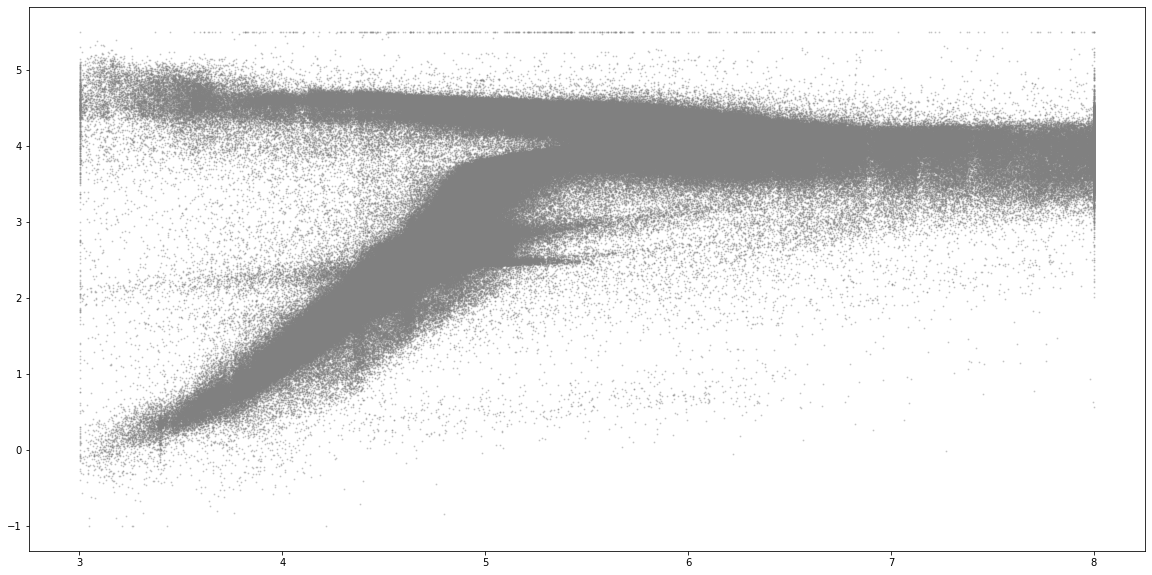

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(GALAH_DR4['teff'].values / 1000, GALAH_DR4['logg'].values, c='gray', s=1, alpha=0.3)
plt.plot(model.param_data['teff_1'], model.param_data['logg_1'], '.', label='Component 1', ls='-', lw=1, c='orange', alpha=0.5)
plt.scatter(model.param_data['teff_1'][-1], model.param_data['logg_1'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_1'][0], model.param_data['logg_1'][0], label='Component 1', s=350,  c='red', marker='.')

plt.plot(model.param_data['teff_2'], model.param_data['logg_2'], 'o', label='Component 2', ls='-', lw=1)
plt.scatter(model.param_data['teff_2'][-1], model.param_data['logg_2'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_2'][0], model.param_data['logg_2'][0], label='Component 1', s=350,  c='red', marker='.')

plt.xlabel('teff 1')
plt.ylabel('logg 1' )
plt.ylim(-1, 5)
plt.xlim(3, 8)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()


plt.figure(figsize=(20,10))
x = np.arange(0, len(model.param_data['teff_1']))
plt.plot(x, model.param_data['teff_1'], 'o', label='Component 1 teff', ls='-', lw=1)
plt.plot(x, model.param_data['teff_2'], 'o', label='Component 2 teff', ls='-', lw=1)

plt.plot(x, model.param_data['logg_1'], 'o', label='Component 1 logg', ls='-', lw=1)
plt.plot(x, model.param_data['logg_2'], 'o', label='Component 2 logg', ls='-', lw=1)
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['residual'], 'o', label='Component 1', ls='-', lw=1)

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['f_contr'], 'o', label='Component 1', ls='-', lw=1)



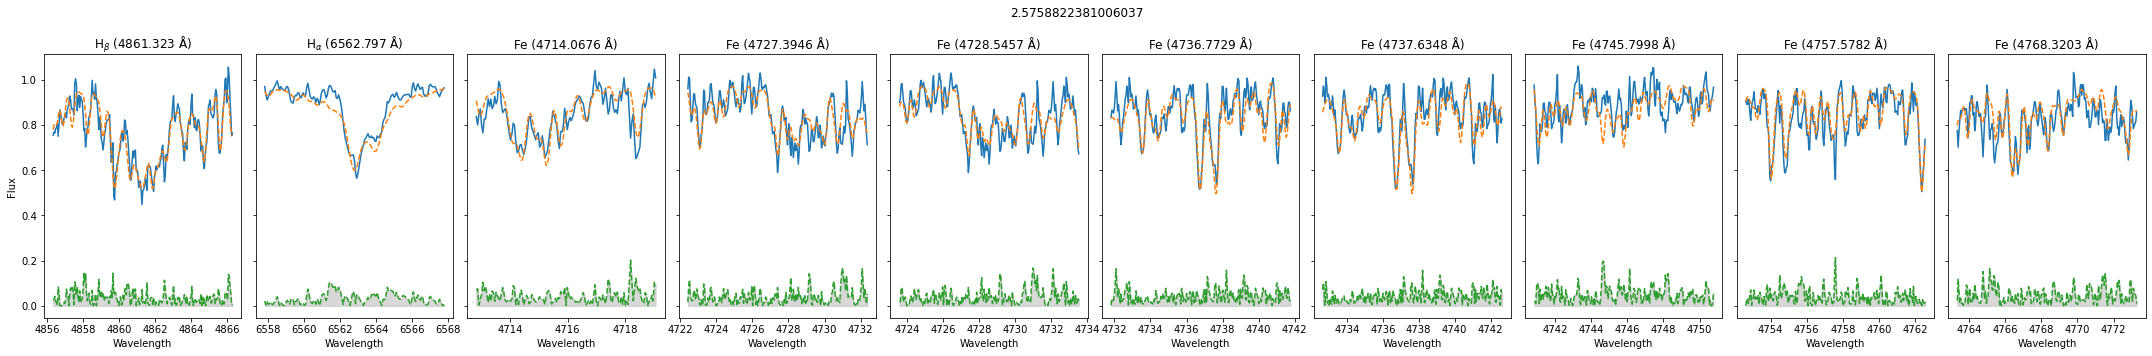

<Table length=15101>
       wave               sob         ...        smod         mob 
     float64            float64       ...      float64        bool
------------------ ------------------ ... ------------------ -----
 4712.807248783402 0.8377494798193145 ... 0.9081564299831242  True
 4712.853270574516 0.8005894656497954 ... 0.8761979950792974  True
 4712.899292365629 0.8473295663129368 ... 0.8515193698275472  True
 4712.945314156742 0.8717163316620767 ... 0.8422177229572496  True
 4712.991335947856 0.8001108438335998 ... 0.8500412280558998  True
 4713.037357738969 0.7655396790019225 ...  0.870041972747887  True
 4713.083379530082 0.8273962972643376 ... 0.8936049267051984  True
4713.1294013211955 0.8267750159678164 ... 0.9129577568931535  True
4713.1754231123095 0.8724902745062434 ... 0.9249173586648332  True
 4713.221444903422 0.9163271097782089 ... 0.9309986954473637  True
               ...                ... ...                ...   ...
 7884.591195401748 0.9846478259276189 ... 0.9881728401239489  True
 7884.664740499734  0.956912084959346 ... 0.9895947810262393  True
 7884.738285597719 0.9481407213957243 ... 0.9884991262145292  True
 7884.811830695705 0.9796450824239187 ... 0.9849432855811963  True
7884.8853757936895   0.97802263437115 ... 0.9794986909618244  True
 7884.958920891675  1.006258344965112 ... 0.9736694901856913  True
 7885.032465989661 1.0068053124664607 ... 0.9694990901250128  True
 7885.106011087647 1.0294041784317165 ...   0.96829939968855  True
7885.1795561856325 1.1048133131624416 ... 0.9703885236621161  True
 7885.253101283618  1.190953625769364 ... 0.9753735372724525 False

In [60]:

# Save spectrum
save_spectrum = Table()
save_spectrum['wave'] = wave_iter1
save_spectrum['sob'] = data_iter1
save_spectrum['uob'] = np.sqrt(sigma2_iter1)
save_spectrum['smod'] = model_iter1
save_spectrum['mob'] = unmasked_iter1

save_spectrum